In [17]:
# -*- coding: utf8 -*-
import re
import sys
import argparse
import pymorphy2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBClassifier
from sklearn import linear_model, metrics
from scipy import interp

import theano
import theano.tensor as T
import lasagne

%matplotlib inline

data_file = "data/train.txt"
vocab_file = "data/vocab.txt"
stopwords_file = "data/stopwords.txt"
win_size = 11

In [18]:
vocab = []
word_inds = {}
with open(vocab_file, "r") as f:
    s = f.read()
    vocab = s.split(',')
    
for i, w in enumerate(vocab):
    word_inds[w] = i
stopwords = []
with open(stopwords_file, "r") as f:
    s = f.read()
    stopwords = s.split(',')
brands = ["mercedes", "bmw", "mitsubishi","тойота","hyundai","ford","nissan","audi","lexus",
          "chevrolet","opel","peugeot","mazda","лексус","volvo", "мазд", "мицубись", "ситройня", 
          "киа", "renault","kia", "toyota"]

In [19]:
morph = pymorphy2.MorphAnalyzer()

def f(word):
    x = morph.parse(word)[0].normal_form
    if re.match("[0-9]+", x):
        return "_number"
    elif x in brands:
        return "_brand"
    else: return x

def process_table(table):
    data = table[1].str.split(',', 2).apply(pd.Series, 1)
    data = data[data[2] != ""]
    data[2] = data[2].apply(lambda x: str(x)[9:-3])
    data.columns = ["id", "label", "text"]
    data['label'] = data['label'].apply(lambda x: '1' if x == '3' or x == '4' else '0')
    return data

def process_text(text):
    sample = re.split('\W+', re.sub('\W(Н|н)(е|Е) ', ' не', text))
    l = [f(x) for x in sample if f(x) not in stopwords]
    text = ' '.join(l)
    return text

def process(path):
    data = pd.read_csv(path, delimiter='autoru-', header = None, quoting=3, engine='python')
    data = process_table(data)
    data['text'] = data['text'].apply(lambda x: process_text(x))
    data.to_csv(path + ".proc.txt", sep='\t', encoding='utf-8')
    return data


In [20]:
def read_chunk(f, delimiter):
    buf = ""
    while True:
        while delimiter in buf:
            pos = buf.index(delimiter)
            yield buf[:pos]
            buf = buf[pos + len(delimiter):]
        chunk = f.read(2048)
        if not chunk:
            yield buf
            break
        buf += chunk


def get_data(input, flag):
    data, labels = [], []
    max_size = 0
    if flag:
        train_data = process(input)
        data, labels = train_data['text'], train_data['label']
        
    else:
        with open(input) as f:
            gen = read_chunk(f, "\n")
            for i in range(40000):
                s = next(gen).split('\t')
                data.append(s[-1])
                max_size = max(max_size, len(s[-1].split()))
                labels.append(s[-2])
    return np.array(data), np.array(labels).astype(int), max_size

data, labels, max_size = get_data(data_file, False)
inv_labels = np.logical_not(labels)
max_size += 1

In [21]:
def get_word_frequencies(some_data, out_file):
    word_freq = {}
    vectorizer = CountVectorizer(vocabulary=vocab)
    data_features = vectorizer.fit_transform(some_data).toarray()
    words = vectorizer.get_feature_names()
    frequencies = np.sum(data_features, axis=0)
    #with open(out_file, "w+") as f:
    for i, (fr, word) in enumerate(sorted(zip(frequencies, words), reverse=True)):
        if word not in stopwords:
            #f.write(str(fr) + ' ' + word + '\n')
            word_freq[word] = i + 1
    return word_freq

#good = get_word_frequencies(data[labels], "data/clean_good_vocab.txt")
#bad = get_word_frequencies(data[inv_labels], "data/clean_bad_vocab.txt")

def preprocess(data):
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] != 0:
                val = (bad[vocab[j]] if vocab[j] in bad else len(bad) / (good[vocab[j]] if vocab[j] in good else len(good)))
                data[i][j] = data[i][j] * val
            if not np.isfinite(data[i][j]):
                print(vocab[j])
    return data

In [22]:
def contextwin(l, w_size, max_size):
    assert (w_size % 2) == 1
    assert w_size >= 1
    l = list(l)
    lpadded = (w_size // 2 * [-1]) + l + (max_size - len(l)) * [-1] + (w_size // 2 * [-1])
    out = [lpadded[i:(i + w_size)] for i in range(max_size)]
    return np.array(out).astype(int)

def text_to_win(data, w_size, max_size):
    inds = []
    max_len = 0
    for d in data:
        
        processed = np.array([word_inds[w] + 1 if w in vocab else 0 for w in d.split()])
        max_len = len(processed) if len(processed) > max_len else max_len
        x = contextwin(processed, w_size, max_size)
        inds.append(np.array([contextwin(processed, w_size, max_size)]))
    return inds, max_len
processed_data, max_len = text_to_win(data, win_size, max_size)

In [23]:
np.array(processed_data).shape

(40000, 1, 1084, 11)

In [30]:
def build_mlp(input_var=None):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, max_size, win_size),input_var=input_var)
    l_conv1 = lasagne.layers.Conv2DLayer(
        l_in, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    
    l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))
    l_conv2 = lasagne.layers.Conv2DLayer(
            l_pool1, num_filters=32, filter_size=(2, 2),
            nonlinearity=lasagne.nonlinearities.rectify)
    l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))

    l_dense1 = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(l_pool2, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    l_out = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(l_dense1, p=.5),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [31]:
def with_NN(X_train, y_train, X_test, y_test):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')
    # Create neural network model
    network = build_mlp(input_var)
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)
    
    #validation
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

    # theano functions
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    test_fn = theano.function([input_var, target_var], test_prediction, on_unused_input='warn')
    num_epochs = 20
    # training
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        print (epoch)
        train_err = 0
        train_batches = 0
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("  training loss:{:.6f},    validation loss:{:.6f}".format(
                train_err / train_batches, val_err / val_batches))
        print("{},  validation accuracy:\t\t{:.2f} %".format(epoch + 1, val_acc / val_batches * 100))
    
    test_err, test_acc, test_batches = 0, 0, 0
    tp, tn, fp, fn = 0, 0, 0, 0
    dtrain_predictions, dtrain_predprob, dtrain_targets = [], [], []
    
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        pred = test_fn(inputs, targets)
        preds = [1 if fst < 0.5 else 0 for (fst, snd) in pred]
        dtrain_predictions.extend(preds)
        dtrain_predprob.extend([snd for (fst, snd) in pred])
        dtrain_targets.extend(targets)
        for value, prediction in zip(targets, preds):
            if (prediction and value):
                tp += 1
            if (prediction and not value):
                fp += 1
            if (not prediction and value):
                fn += 1
            if (not prediction and not value):
                tn += 1
          
        test_err += err
        test_acc += acc
        test_batches += 1
    print("NN:")
    print ('TP: {0}, TN: {1}, FP: {2}, FN: {3}'.format(tp, tn, fp, fn))
    print ("Precision Score : %f" % metrics.precision_score(targets, preds))
    print ("Recall Score : %f" % metrics.recall_score(targets, preds))
    print ("Accuracy : %.4g" % metrics.accuracy_score(targets, preds)) 
    print ("AUC : %f" % metrics.roc_auc_score(targets, preds))
    #print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    #print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
    return dtrain_predictions, dtrain_predprob, dtrain_targets

In [32]:
def testNN(with_probas=True):
    cv = StratifiedKFold(labels, n_folds=5)
    for i, (train, test) in enumerate(cv):
        vectorizer = CountVectorizer(vocabulary=vocab)
        #features = vectorizer.fit_transform(data[train])
        
        # preprocessing with tfidf
        #transformer = TfidfTransformer()
        #tfidf_features = transformer.fit(features).transform(features)
        #X = tfidf_features.toarray()
        
        # preprocessing with bad/good ranking
        #X_train = preprocess(features.toarray())
        
        X_train, y_train = np.array(processed_data)[train], np.array(labels[train]).astype(np.int32)
        X_test, y_test = np.array(processed_data)[test], np.array(labels[test]).astype(np.int32)
        #X_test = preprocess(X_test.toarray())
        
        res, res_p, l = with_NN(X_train, y_train, X_test, y_test)
        
        fpr, tpr, _ = roc_curve(l, res_p)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        check = zip(y_test, res)
        tp, tn, fp, fn = 0, 0, 0, 0
        for value, prediction in check:
            if (prediction and value):
                tp += 1
            if (prediction and not value):
                fp += 1 
            if (not prediction and value):
                fn += 1
            if (not prediction and not value):
                tn += 1
        print ('TP: {0}, TN: {1}, FP: {2}, FN: {3}'.format(tp, tn, fp, fn))
        print ("Precision Score : %f" % metrics.precision_score(y_test, res))
        print ("Recall Score : %f" % metrics.recall_score(y_test, res))
        print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, res))
    if with_probas:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

testNN()

/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: targets.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.


0
  training loss:41728712855801718370435664434356486348221534182598446069310921478641951453473788333126761911043549544184987382184809594880.000000,    validation loss:75302280491803929369303166188423131990338776799756120308355482087963373028767401448816735339965175243886016019300352000.000000
1,  validation accuracy:		93.61 %
1
  training loss:nan,    validation loss:nan
2,  validation accuracy:		93.61 %
2
  training loss:nan,    validation loss:nan
3,  validation accuracy:		93.61 %
3


KeyboardInterrupt: 

In [35]:
def with_all(d_train, l_train, d_test, l_test):
    #clf1 = RandomForestClassifier(n_estimators=20)
    skf = list(StratifiedKFold(l_train, 5))

    clfs = [RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
            RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
            ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
            ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
            GradientBoostingClassifier(subsample=0.5, max_depth=6, n_estimators=50)]
    
    dataset_blend_train = np.zeros((d_train.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((d_test.shape[0], len(clfs)))
    
    for j, clf in enumerate(clfs):
        print (clf)
        dataset_blend_test_j = np.zeros((d_test.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            X_train = d_train[train]
            y_train = l_train[train]
            X_test = d_train[test]
            y_test = l_train[test]
            clf.fit(X_train, y_train)
            y_submission = clf.predict_proba(X_test)[:,1]
            dataset_blend_train[test, j] = y_submission
            dataset_blend_test_j[:, i] = clf.predict_proba(d_test)[:,1]
        dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)

    clf = LogisticRegression()
    clf.fit(dataset_blend_train, l_train)
    dtrain_predprob = clf.predict_proba(dataset_blend_test)[:, 1]
    dtrain_predictions = [1 if dtrain_predprob[i] > 0.42 else 0 for i in range(len(dtrain_predprob))]
    check = zip(l_test, dtrain_predictions)
    tp, tn, fp, fn = 0, 0, 0, 0
    for value, prediction in check:
        if (prediction and value):
            tp += 1
        if (prediction and not value):
            fp += 1 
        if (not prediction and value):
            fn += 1
        if (not prediction and not value):
            tn += 1
    print ('All: TP: {0}, TN: {1}, FP: {2}, FN: {3}'.format(tp, tn, fp, fn))
    print ("Accuracy : %.4g" % metrics.accuracy_score(l_test, dtrain_predictions))
    print ("AUC : %f" % metrics.roc_auc_score(l_test, dtrain_predprob))
    print ("Precision : %f" % metrics.precision_score(l_test, dtrain_predictions))
    print ("Recall : %f" % metrics.recall_score(l_test, dtrain_predictions))
    return dtrain_predictions, dtrain_predprob

def with_KNN(X_train, y_train, X_test, y_test):
    X, X1, y, y1 = train_test_split(X_train, y_train, test_size=0.5)
    clf1 = RandomForestClassifier(n_estimators=40)
    clf2 = KNeighborsClassifier()
    enc = OneHotEncoder()
    clf1.fit(X, y)
    enc.fit(clf1.apply(X))
    clf2.fit(enc.transform(clf1.apply(X1)), y1)
    res = clf2.predict(enc.transform(clf1.apply(X_test))) 
    res_p = clf2.predict_proba(enc.transform(clf1.apply(X_test)))[:, 1]
    #feat_imp = sorted(zip(clf2.feature_importances_, range(len(vocab))), reverse=True)
    check = zip(y_test, res)
    tp, tn, fp, fn = 0, 0, 0, 0
    for value, prediction in check:
        if (prediction and value):
            tp += 1
        if (prediction and not value):
            fp += 1 
        if (not prediction and value):
            fn += 1
        if (not prediction and not value):
            tn += 1
    print (' KNN: TP: {0}, TN: {1}, FP: {2}, FN: {3}'.format(tp, tn, fp, fn))
    print ("Precision Score : %f" % metrics.precision_score(y_test, res))
    print ("Recall Score : %f" % metrics.recall_score(y_test, res))
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, res))
    return res, res_p
        
def with_XGB(X_train, y_train, X_test, y_test):
    clf = XGBClassifier(learning_rate =0.03, n_estimators=150, max_depth=6,
                        min_child_weight=4, gamma=0.1, subsample=0.8, 
                        colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=27)
    clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    res_p = clf.predict_proba(X_test)[:, 1]
    
    feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
    feat_ind = [ vocab[int(f[1:])] for f in feat_imp.index]
    words_imp = zip(feat_imp.values, feat_ind)
    #print((list)words_imp[:10])
    check = zip(y_test, res)
    tp, tn, fp, fn = 0, 0, 0, 0
    for value, prediction in check:
        if (prediction and value):
            tp += 1
        if (prediction and not value):
            fp += 1 
        if (not prediction and value):
            fn += 1
        if (not prediction and not value):
            tn += 1
    print ('XGB: TP: {0}, TN: {1}, FP: {2}, FN: {3}'.format(tp, tn, fp, fn))
    print ("Precision Score : %f" % metrics.precision_score(y_test, res))
    print ("Recall Score : %f" % metrics.recall_score(y_test, res))
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, res))
    #feat_imp = sorted(zip(clf2.feature_importances_, range(len(vocab))), reverse=True)
    return res, res_p

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oo

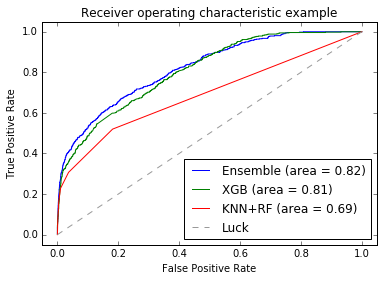

In [37]:
def test(with_probas=True):
    cv = StratifiedKFold(labels, n_folds=5)
    for i, (train, test) in enumerate(cv):
        if i == 0:
            vectorizer = CountVectorizer(vocabulary=vocab)
            features = vectorizer.fit_transform(data[train])

            # preprocessing with tfidf
            #transformer = TfidfTransformer()
            #tfidf_features = transformer.fit(features).transform(features)
            #X = tfidf_features.toarray()

            # preprocessing with bad/good ranking
            #X_train = preprocess(features.toarray())

            X_train, y_train = features.toarray(), labels[train]
            X_test, y_test = vectorizer.transform(data[test]).toarray(), labels[test]
            #X_test = preprocess(X_test.toarray())

            res, res_p = with_all(X_train, y_train, X_test, y_test)
            fpr, tpr, _ = roc_curve(y_test, res_p)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label='Ensemble (area = %0.2f)' % (roc_auc))            
            
            res, res_p = with_XGB(X_train, y_train, X_test, y_test)
            fpr, tpr, _ = roc_curve(y_test, res_p)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label='XGB (area = %0.2f)' % (roc_auc))            
            
            res, res_p = with_KNN(X_train, y_train, X_test, y_test)
            fpr, tpr, _ = roc_curve(y_test, res_p)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label='KNN+RF (area = %0.2f)' % (roc_auc))

            plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()

test()